# UCI Heart Disease Data Analysis (Python)

I will perform a simple analysis on the Heart Disease UCI dataset published on Kaggle (https://www.kaggle.com/ronitf/heart-disease-uci/data). The dataset contains 13 attributes, which may link to the disease, from 303 patients.

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

I will first import the data and have a glance at the first few rows.

In [3]:
dataset = pd.read_csv('heart.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


I will then preprocess the data with the following procedures:
<ol>
    <li> Create dummy variables for cp, restecg, ca, and thal.
    <li> Drop one of the mentioned columns to prevent collinearity. 

In [4]:
dataset['thal'] = dataset['thal'].replace(1, 'fixed defect')
dataset['thal'] = dataset['thal'].replace(2, 'normal')
dataset['thal'] = dataset['thal'].replace(3, 'reversable defect')

dataset['cp'] = dataset['cp'].replace(0, 'asymptomatic')
dataset['cp'] = dataset['cp'].replace(1, 'atypical angina')
dataset['cp'] = dataset['cp'].replace(2, 'non-anginal pain')
dataset['cp'] = dataset['cp'].replace(3, 'typical angina')

dataset['restecg'] = dataset['restecg'].replace(0, 'ventricular hypertrophy')
dataset['restecg'] = dataset['restecg'].replace(1, 'normal')
dataset['restecg'] = dataset['restecg'].replace(2, 'ST-T wave abnormality')

dataset['slope'] = dataset['slope'].replace(0, 'downsloping')
dataset['slope'] = dataset['slope'].replace(1, 'normal')
dataset['slope'] = dataset['slope'].replace(2, 'upsloping')

In [5]:
temp = pd.get_dummies(dataset[['cp', 'restecg', 'slope', 'thal']])
dataset = dataset.join(temp, how='left')
dataset.drop(['cp','restecg','slope','thal'], axis=1, inplace=True)
dataset.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_asymptomatic,cp_atypical angina,cp_non-anginal pain,cp_typical angina,restecg_ST-T wave abnormality,restecg_normal,restecg_ventricular hypertrophy,slope_downsloping,slope_normal,slope_upsloping,thal_0,thal_fixed defect,thal_normal,thal_reversable defect
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,0.148515,149.646865,0.326733,1.039604,0.729373,0.544554,0.471947,0.165017,0.287129,0.075908,0.013201,0.501650,0.485149,0.069307,0.462046,0.468647,0.006601,0.059406,0.547855,0.386139
std,9.082101,0.466011,17.538143,51.830751,0.356198,22.905161,0.469794,1.161075,1.022606,0.498835,0.500038,0.371809,0.453171,0.265288,0.114325,0.500824,0.500606,0.254395,0.499382,0.499842,0.081110,0.236774,0.498528,0.487668
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,153.000000,0.000000,0.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,140.000000,274.500000,0.000000,166.000000,1.000000,1.600000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next, I will perform Feature Selection. I will only select variables with the absolute value of a correlation coefficient of less than 0.8. This will eliminate highly correlated varaibles which can lead to collinearity issues.

In [6]:
dataset = dataset.drop(columns = ['restecg_ventricular hypertrophy', 'slope_upsloping', 'thal_fixed defect', 'cp_typical angina'], axis=1)
dataset.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_asymptomatic,cp_atypical angina,cp_non-anginal pain,restecg_ST-T wave abnormality,restecg_normal,slope_downsloping,slope_normal,thal_0,thal_normal,thal_reversable defect
0,63,1,145,233,1,150,0,2.3,0,1,0,0,0,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,0,1,0,1,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,0,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,0,1,0,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,1,0,0,0,1,0,0,0,1,0


In [7]:
correlated_matrix = dataset.corr()
correlated_variables = set()
for col in range(len(correlated_matrix.columns)):
    for other in range(col):
        if abs(correlated_matrix.iloc[col, other]) > 0.8:
            correlated_variables.add(correlated_matrix.columns[col])
dataset.drop(correlated_variables, axis=1)
dataset.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_asymptomatic,cp_atypical angina,cp_non-anginal pain,restecg_ST-T wave abnormality,restecg_normal,slope_downsloping,slope_normal,thal_0,thal_normal,thal_reversable defect
0,63,1,145,233,1,150,0,2.3,0,1,0,0,0,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,0,1,0,1,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,0,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,0,1,0,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,1,0,0,0,1,0,0,0,1,0


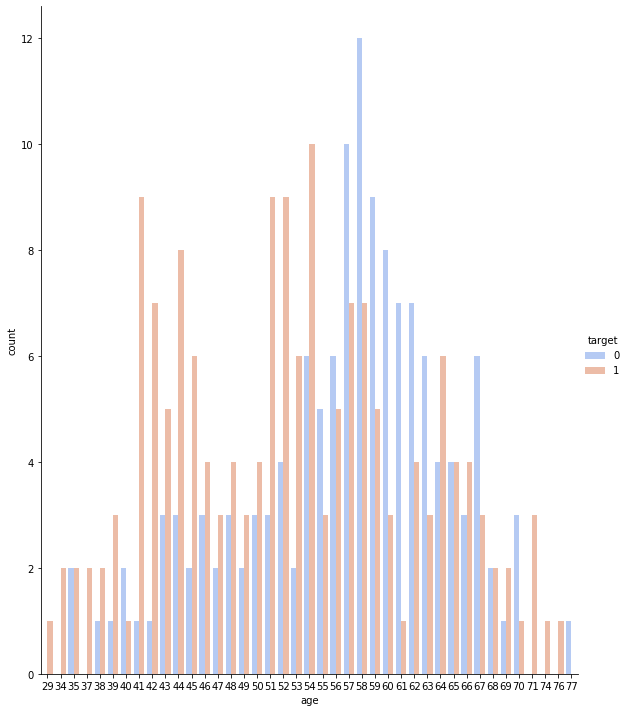

In [8]:
sns.factorplot('age', kind='count', hue='target', data=dataset, palette='coolwarm', height=10, aspect=.8)

I will then run RFEVC to find vairables that are useful to the model.

In [9]:
X = dataset.drop(['target'], axis=1)
y = dataset['target']

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=10)

rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()

In [10]:
grid_search = GridSearchCV(estimator = rf, param_grid = dict(), 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search.fit(train_features, train_labels);

grid_search.best_params_
best_grid = grid_search.best_estimator_
print(best_grid.get_params())

selector = RFE(rf, step=1, verbose=3)
selector = selector.fit(train_features, train_labels)
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Features sorted by their rank:
[(1, 'age'), (1, 'ca'), (1, 'chol'), (1, 'cp_asymptomatic'), (1, 'cp_non-anginal pain'), (1, 'oldpeak'), (1, 'thal_normal'), (1, 'thalach'), (1, 'trestbps'), (2, 'sex'), (3, 'thal_reversable defect'), (4, 'slope_normal'), (5, 'e

In [13]:
rf = RandomForestClassifier(**best_grid.get_params())

rf.fit(train_features, train_labels)
dt.fit(train_features, train_labels)
lr.fit(train_features, train_labels)
knn.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
rf_pred_train = rf.predict(train_features)
dt_pred_train = dt.predict(train_features)
lr_pred_train = lr.predict(train_features)
knn_pred_train = knn.predict(train_features)
rf_pred_test = rf.predict(test_features)
dt_pred_test = dt.predict(test_features)
lr_pred_test = lr.predict(test_features)
knn_pred_test = knn.predict(test_features)

In [19]:
print(classification_report(test_labels,rf_pred_test))
print('Random Forest baseline: ' + str(roc_auc_score(train_labels, rf_pred_train)))
print('Random Forest: ' + str(roc_auc_score(test_labels, rf_pred_test)))
print(classification_report(test_labels,dt_pred_test))
print('Decision Tree baseline: ' + str(roc_auc_score(train_labels, dt_pred_train)))
print('Decision Tree: ' + str(roc_auc_score(test_labels, dt_pred_test)))
print(classification_report(test_labels,lr_pred_test))
print('Logistic Regression baseline: ' + str(roc_auc_score(train_labels, lr_pred_train)))
print('Logistic Regression: ' + str(roc_auc_score(test_labels, lr_pred_test)))
print(classification_report(test_labels,knn_pred_test))
print('KNN baseline: ' + str(roc_auc_score(train_labels, knn_pred_train)))
print('KNN: ' + str(roc_auc_score(test_labels, knn_pred_test)))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        35
           1       0.78      0.81      0.79        26

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Random Forest baseline: 0.9892086330935252
Random Forest: 0.8181318681318681
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        35
           1       0.67      0.77      0.71        26

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.75      0.74      0.74        61

Decision Tree baseline: 1.0
Decision Tree: 0.7417582417582418
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.74      0.77      0.75        26

    accuracy                           0.79

NameError: name 'eliminator' is not defined

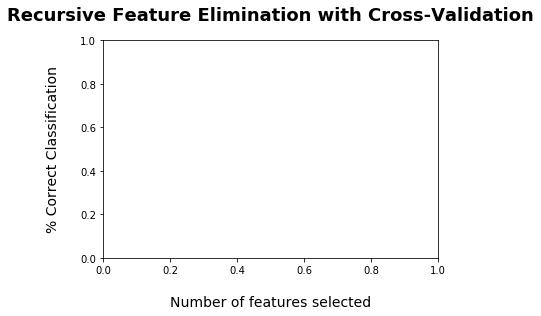

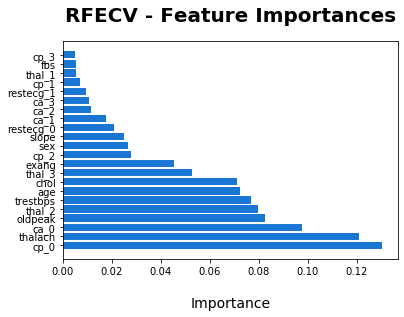